In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def leer_archivo(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    dimension = 0
    pesos_aristas = []
    reading_weights = False
    
    for line in lines:
        if line.startswith("DIMENSION"):
            dimension = int(line.split()[-1])
        elif line.startswith("EDGE_WEIGHT_SECTION"):
            reading_weights = True
            continue
        elif line.startswith("EOF"):
            break
        elif reading_weights:
            pesos_aristas.extend(map(int, line.split()))
            
    return dimension, pesos_aristas

In [3]:
def crear_grafo_ATSP(dimension, pesos_aristas):

    G = nx.DiGraph()

    index = 0
    for i in range(dimension):
        for j in range(dimension):
            if i != j:
                weight = pesos_aristas[index]
                if weight > 0:
                    G.add_edge(i, j, weight=weight)
            index += 1

    return G

In [4]:
def visualizar_grafo(G):
    pos = nx.spring_layout(G)  # positions for all nodes
    edge_labels = {(u, v): data['weight'] for u, v, data in G.edges(data=True)}
    
    plt.figure(figsize=(10, 10))
    
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_weight='bold', arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title("Graph Visualization of ATSP")
    plt.show()

In [5]:
def calcular_costo(G, solucion):
    total_cost = 0
    
    for i in range(len(solucion) - 1):
        total_cost += G[solucion[i]][solucion[i+1]]['weight']
        
    total_cost += G[solucion[-1]][solucion[0]]['weight']
    
    return total_cost

In [6]:
def visualize_hamiltonian_circuit(G, circuit):
    pos = circular_layout_based_on_circuit(circuit)
    plt.figure(figsize=(10, 10))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist=circuit, node_size=700, node_color='skyblue')

    # Draw only the edges in the circuit
    edges = [(circuit[i], circuit[i + 1]) for i in range(len(circuit) - 1)]
    edges.append((circuit[-1], circuit[0]))  # Close the circuit
    
    edge_labels = {(u, v): G[u][v]['weight'] for u, v in edges}
    
    
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='blue', width=2, arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    plt.title("Hamiltonian Circuit Visualization")
    plt.show()

def circular_layout_based_on_circuit(circuit):
    num_nodes = len(circuit)
    angle_step = 2 * np.pi / num_nodes
    pos = {}
    for i, node in enumerate(circuit):
        angle = i * angle_step
        pos[node] = np.array([np.cos(angle), np.sin(angle)])
    return pos

In [7]:
def heuristica_1(G):
    start_node = 0
    visited = [start_node]
    current_node = start_node

    while len(visited) < len(G.nodes):
        next_node = min(
            (node for node in G.neighbors(current_node) if node not in visited),
            key=lambda node: G[current_node][node]['weight'],
            default=None
        )
        if next_node is None:
            break
        
        visited.append(next_node)
        current_node = next_node
    
    # Return to the start node to complete the circuit
    total_cost = calcular_costo(G, visited)
    
    return visited, total_cost

In [8]:
def es_factible(G, circuit):
    
    for i in range(len(circuit) - 1):
        if not G.has_edge(circuit[i], circuit[i + 1]):
            return False
    
    if not G.has_edge(circuit[-1], circuit[0]):
        return False
    
    return True

In [9]:
def operador_swap(G,solucion):

    neighborhood = []

    # Get all pairs (i, j) where i != j
    for i in range(len(solucion)):
        for j in range(i + 1, len(solucion)):
            # Swap the nodes at position i and j
            nueva_solucion = solucion[:]
            nueva_solucion[i], nueva_solucion[j] = nueva_solucion[j], nueva_solucion[i]
            if es_factible(G,nueva_solucion):
                neighborhood.append(nueva_solucion)

    return neighborhood

In [10]:
def operador_insert(solucion):

    neighborhood = []

    # Iterate over all nodes in the circuit
    for i in range(len(solucion)):
        # Remove node from its current position
        nodo = solucion[i]
        solucion_temp = solucion[:i] + solucion[i+1:]

        # Insert node in every possible position in the reduced circuit
        for j in range(len(solucion_temp) + 1):
            nueva_solucion = solucion_temp[:j] + [nodo] + solucion_temp[j:]
            if es_factible(G,nueva_solucion):
                neighborhood.append(nueva_solucion)

    return neighborhood

In [11]:
def busqueda_local(G, solucion, operador:str):
    
        best_solution = solucion
        best_cost = calcular_costo(G, best_solution)
    
        while True:
            
            if operador == "swap":
                neighborhood = operador_swap(G,best_solution)
            elif operador == "insert":
                neighborhood = operador_insert(best_solution)
                
            improved = False
    
            for neighbor in neighborhood:
                cost = calcular_costo(G, neighbor)
                
                if cost < best_cost:
                    best_solution = neighbor
                    best_cost = cost
                    improved = True
    
            if not improved:
                break
    
        return best_solution, best_cost

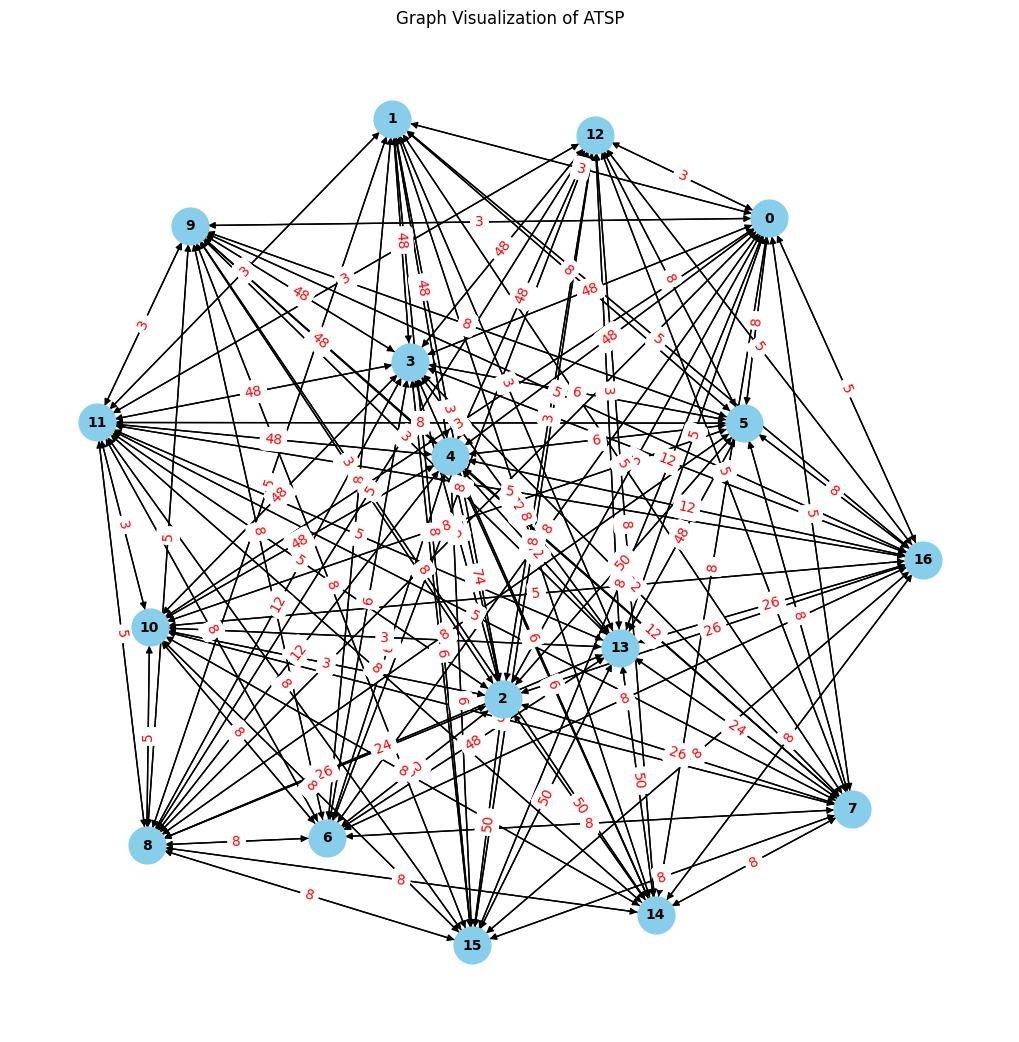

In [21]:
# Example usage
filename = './instancias/br17.atsp'
dimension, pesos_aristas = leer_archivo(filename)

G = crear_grafo_ATSP(dimension, pesos_aristas)

visualizar_grafo(G)

# Print the edges with weights
# for u, v, data in G.edges(data=True):
#     print(f"({u}, {v}, {data['weight']})")

Costo total:  87
[0, 1, 2, 9, 11, 10, 13, 12, 7, 5, 3, 6, 4, 14, 8, 15, 16]


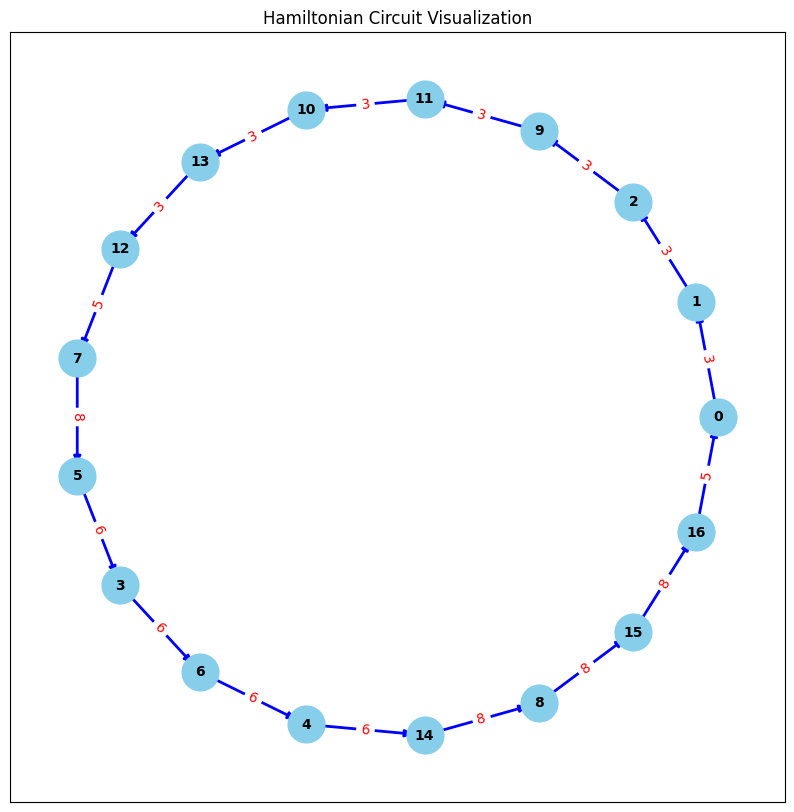

In [22]:
CH_heuristica1,total_cost = heuristica_1(G)

print("Costo total: ", total_cost)  
print(CH_heuristica1)

visualize_hamiltonian_circuit(G, CH_heuristica1)

Solucion inicial:  [0, 1, 2, 9, 11, 10, 13, 12, 7, 5, 3, 6, 4, 14, 8, 15, 16]
Costo incial:  87
Solucion mejorada con insert:  [0, 1, 2, 9, 11, 10, 13, 12, 7, 5, 3, 6, 4, 14, 8, 15, 16]
Costo total:  87
Solucion mejorada con swap:  [0, 1, 2, 9, 11, 10, 13, 12, 7, 5, 3, 6, 4, 14, 8, 15, 16]
Costo total:  87


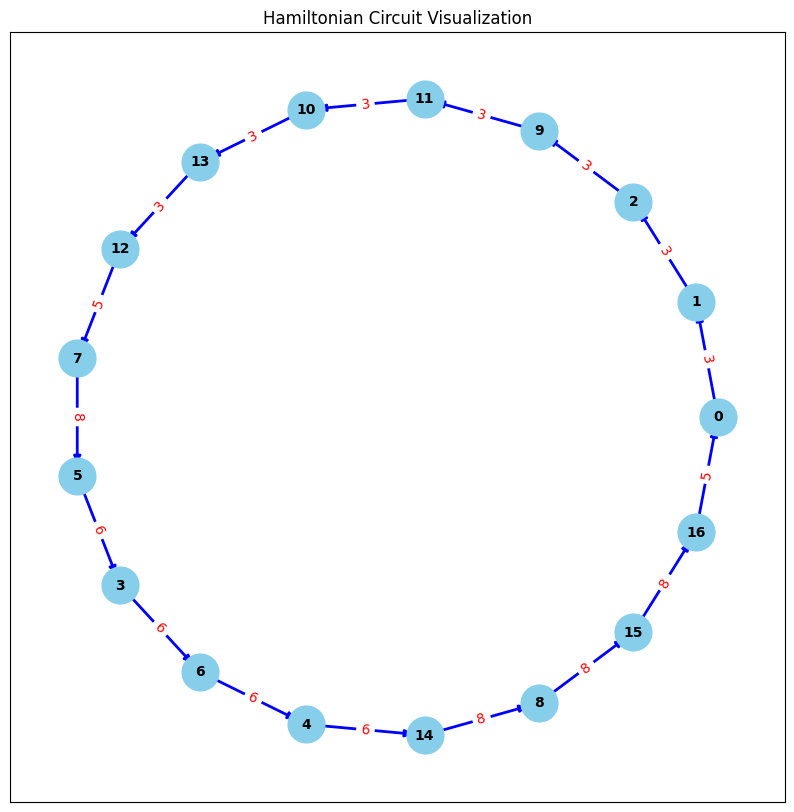

In [23]:
print("Solucion inicial: ", CH_heuristica1)
print("Costo incial: ", total_cost)

solucion_mejorada_insert = busqueda_local(G, CH_heuristica1, "insert")

print("Solucion mejorada con insert: ", solucion_mejorada_insert[0])
print("Costo total: ", solucion_mejorada_insert[1])

solucion_mejorada_swap = busqueda_local(G, CH_heuristica1, "swap")

print("Solucion mejorada con swap: ", solucion_mejorada_swap[0])
print("Costo total: ", solucion_mejorada_swap[1])

if solucion_mejorada_insert[1] < solucion_mejorada_swap[1]:
    visualize_hamiltonian_circuit(G, solucion_mejorada_insert[0])
elif solucion_mejorada_insert[1] > solucion_mejorada_swap[1]:
    visualize_hamiltonian_circuit(G, solucion_mejorada_swap[0])
else:
    visualize_hamiltonian_circuit(G, CH_heuristica1)